# Introduction
This post is a small introduction to the material provided for the neural network [competition](https://competitions.codalab.org/competitions/19711) in the intensive course in computing of the UAB's Bachelor's Degree in Computer Engineering. The code for this blog post can be found [here](https://github.com/DataUAB/Pytorch-Mnist-done-wrong), along with the rest of the competition kit. 

The competition consists in creating a neural network that can solve a multiclass classification problem (**MNIST**).  

**MNIST** is a very simple dataset consisting of binary images (black and white images) of handwritten digits with a size of 28x28 pixels. The task is to create a model that tell which digit is written on each image.



## Competition Kit

1. [Dataset](https://github.com/DataUAB/Pytorch-Mnist-done-wrong) of digits images. The dataset has been split into the following sets:

Train: The neural network will be trained on this set.
Validation: The network trained with the Train set must be evaluated using this set.
Test: At the end of the competition you will be provided with a new unlabeled data set from where you will get the final score of the competition with the predictions of your network.
2. [Pytorch Library for Python.](https://pytorch.org/docs/stable/index.html)
3. [Sample Code](https://github.com/DataUAB/Pytorch-Mnist-done-wrong).


## Competition 

To participate in the competition a member of the group must register at [Codalab] (https://competitions.codalab.org/competitions/19711).
To make a submission, you must upload a ZIP file with the predictions generated by the bash script "run_tests.sh" in the example code that you can find [here](https://github.com/DataUAB/Pytorch-Mnist-done-wrong), along with the rest of the competition kit. This file, called "predictions_class.pkl", will be found in the directory competition/results/final/.

Only compress the .pkl file, without including the path to any directory within the ZIP.

You will see the accuracy that your model has achieved in the results section along with the ranking of all participants.


# First Approach

This competition introduces the participants to the practical use of neural networks within the framework of the multi-class classification. For this, we must master the concepts related to neural networks and the associated parameters.

The purpose of this section is to train a neural network as a classifier for each of the categories in the MNIST dataset. Specifically, you will have to train a neural network for each type of digit in the database $y \in \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9 \}$ . In total, there will be 10 binary classifiers, which will return $1$ if the input belongs to the class with which the classifier has been trained and $0$ otherwise.

It is recommended that the groups, while participating in the competition:

1. Study of the influence of different parameters in the 10 classifiers obtained(one for each class). With special emphasis on:
 - Learning rate
 - Number of layers
 - Name of neurons
 - Transfer functions
 - Standardization of features
 - Training algorithm
 
 ![](images/nn.jpeg)

2. Other parameters encountered in the PyTorch documentation (it is very mportant to review the documentation).

3. We recommend that you make a table with the different tested parameters and the results obtained. For example:

 ![](images/results.png)

Here's an interactive sample code and an example illustrating how PyTorch works. **Remember that each cell depends on the previous one and you must execute them all in order**.


## Pytorch Example

0. Install the library.
1. Choose the selected configuration and follow the instructions specified in the [pytorch page] (https://pytorch.org/).
2. Install dependencies to run this notebook (if you want to run it interactively).
    * `numpy`
    * `matplotlib`
3. [Jupyter notebook] (http://jupyter.org/install).
4. (Optional) Nvidia Drivers and CUDA to allow parallel execution in a GPU.
  
Remember to be consistent with the version of python you use. We recommend using python3.6.


Load the libraries and binarize the training dataset.


In [1]:

%matplotlib inline

import torch # Import main library
from torch.utils.data import DataLoader # Main class for threaded data loading
import matplotlib.pyplot as plt
import numpy as np

# Optimizaiton config
target_class = 3 # Train a classifier for this class
batch_size = 100 # Number of samples used to estimate the gradient (bigger = stable training & bigger learning rate)
learning_rate = 0.05 # Optimizer learning rate
epochs = 100 # Number of iterations over the whole dataset.

# Prepare data
train_data = np.load('competition/train.npy')
val_data = np.load('competition/val.npy')

def select_class(data, clss):
    images = np.array(data.item()["images"])
    labels = np.array(data.item()["labels"])
    labels = (labels == target_class).astype(int)
    return images, labels

train_images, train_labels = select_class(train_data, target_class)
val_images, val_labels = select_class(val_data, target_class)

train_size = train_labels.shape[0]
val_size = val_labels.shape[0]

print(train_size, "training images.")

47995 training images.


Verify that the data has been loaded correctly:

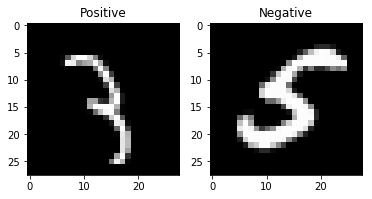

In [2]:
indices = np.arange(train_size)
positive_indices = indices[train_labels == 1]
negative_indices = indices[train_labels == 0]

plt.figure()
plt.subplot(1, 2, 1)
plt.title("Positive")
plt.imshow(train_images[positive_indices[0], :, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Negative")
plt.imshow(train_images[negative_indices[0], :, :], cmap="gray")

We create a neural network with 3 layers: input, output and an hidden layer (layer2). It is important that the input and output dimensions are correct: the entry must be 28 * 28 (number of pixels of the image, which has a size 28 x 28), and the output must be of size 1, since it's a binary classifier.

In [3]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super().__init__() # Necessary for torch to detect this class as trainable
        # Here define network architecture
        self.layer1 = torch.nn.Linear(28**2, 4) # Linear layer with 4 neurons
        self.layer2 = torch.nn.Linear(4, 4) # Linear layer with 4 neurons
        self.output = torch.nn.Linear(4, 1) # Linear layer with 1 neuron (binary output)
    def forward(self, x):
        # Here define architecture behavior
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return torch.sigmoid(self.output(x)) # Binary output
    
# Instantiate network
model = NeuralNet()        

We create the optimizer, declare the function to be optimized, and the rest of the functions to optimize the model.

In [4]:
# Create optimizer for the network parameters
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

# Instantiate loss function
criterion = torch.nn.BCELoss() # Binary logistic regression

# Function to iterate the training set and update network weights with batches of images.
def train(model, optimizer, criterion):
    
    model.train() # training mode
    
    running_loss = 0
    running_corrects = 0
    total = 0
    
    for idx in range(0, train_size, batch_size):       
        optimizer.zero_grad() # make the gradients 0 
        x = torch.from_numpy(train_images[idx:(idx + batch_size), ...]).float()
        y = torch.from_numpy(train_labels[idx:(idx + batch_size), ...]).float()
        output = model(x.view(-1, 28 ** 2)) # forward pass
        preds = (output > 0.5).float()
        
        loss = criterion(output.view_as(y), y) # calculate the loss value
        
        loss.backward() # compute the gradients
        optimizer.step() # uptade network parameters 
                
        # statistics 
        running_loss += loss.item() * x.size(0)
        running_corrects += torch.sum(preds.data.view(-1)==y.data.view(-1)).item() # .item() converts type from torch to python float or int
        total += float(y.size(0))
        
    epoch_loss = running_loss / total # mean epoch loss 
    epoch_acc = running_corrects / total # mean epoch accuracy
    
    return epoch_loss, epoch_acc

# Function to iterate the validation set and update network weights with batches of images.
def val(model, criterion):
    
    model.eval() # validation mode
    
    running_loss = 0
    running_corrects = 0
    total = 0
    
    with torch.no_grad(): # We are not backpropagating trhough the validation set, so we can save speed
        for idx in range(0, val_size, batch_size):       
            x = torch.from_numpy(val_images[idx:(idx + batch_size), ...]).float()
            y = torch.from_numpy(val_labels[idx:(idx + batch_size), ...]).float()
            output = model(x.view(-1, 28 ** 2)) # forward pass
            preds = (output > 0.5).float()

            loss = criterion(output.view_as(y), y) # calculate the loss value

            # statistics 
            running_loss += loss.item() * x.size(0)
            running_corrects += torch.sum(preds.data.view(-1)==y.data.view(-1)).item() # .item() converts type from torch to python float or int
            total += float(y.size(0))
        
    epoch_loss = running_loss / total # mean epoch loss 
    epoch_acc = running_corrects / total # mean epoch accuracy
    
    return epoch_loss, epoch_acc



Iterate over the entire dataset $epochs$ times showing the train loss and accuracy.

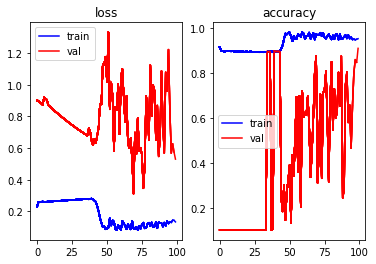

In [5]:
# Main training loop
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Remove this line out of jupyter notebooks
from IPython import display 
for epoch in range(epochs):
    t_loss, t_acc = train(model, optimizer, criterion)
    v_loss, v_acc = val(model, criterion)
    
    train_loss.append(t_loss)
    train_accuracy.append(t_acc)
    val_loss.append(v_loss)
    val_accuracy.append(v_acc)

    plt.subplot(1,2,1)
    plt.title("loss")
    plt.plot(train_loss, 'b-')
    plt.plot(val_loss, 'r-')
    plt.legend(["train", "val"])
    plt.subplot(1,2,2)
    plt.title("accuracy")
    plt.plot(train_accuracy, 'b-')
    plt.plot(val_accuracy, 'r-')
    plt.legend(["train", "val"])
    display.clear_output(wait=True)
    display.display(plt.gcf())
display.clear_output(wait=True)

It should obtain 80 +% train accuracy and valid accuracy. Remember that we are evaluating the images of a class against the rest. Therefore, there will be many more negative images than positive and it is possible to obtain good accuracy by learning to predict always negative. You should find a way to deal with this problem.

# Learning Better

Once different neural network configurations have been tested, we will try to evaluate how good an architecture is by developing the following tasks:
 
* Evaluation and comparison of the different configurations tested, studying the effects of overfiting and underfitting according to the value of the different parameters.
* Calculation of the optimal size of the network based on the number of available data.
* Study the ways to speed up the network, reducing the network time's until convergence by choosing optimal parameters.
* Study the influence of different weight initialization methods.


# Single Model Approach

Once different initializations and neural network architectures have been tested, identifying the best for each class, the task will become training a single neural network with 10 output neurons, one for each class (for example, an output [1 , 0.0,0,0 ...] corresponds to the first class (0); [0,1,0,0,0] means that the neural network classifies the input sample as the class (1); and so on.

Therefore, it is necessary to learn all the samples of all the classes at the same time. When it comes to classifying taking the maximum of the outputs of the 10 neural networks is no longer necessary. Instead classification in class m will correspond to that output neuron that has been activated more strongly.

The changes that must be made in the architecture are trivial, although it is possible that the architecture that worked well with an output must be changed so that it works optimally with 10 outputs:

`self.output = torch.nn.Linear (4, 10) # Linear layer with 10 neurons (number of classes)`

It is not necessary to binarize the exit:

`return self.output (x)`

You must also change the loss function to accept probability distributions:

`criterion = torch.nn.CrossEntropy ()`

Remember that the input of `criterion` for each image is a vector of 10 scores, one for each of the 10 classes, so you must make the corresponding modification so that it has size $batchsize \times 10$ (look the `view_as`).

Regarding the analysis of the results, the use of confusion matrices is recommended:

![](images/confusion.png)


# Conclusions
In this blog post we learned how to take an initial approach to the neural network competition hosted by UAB. We learned how to sign up for the competition and participate. We also saw some tips as to how sucessfully create a classifier for a multi-class problem, going from a more basic approach (10 classifiers), to a more efficient one (1 classifier). 